# Eggers

**Lagrangian:** Geometric Action
<br>
**Implementation:** Python

**System:**

$$
\begin{cases}
    da =& kb(U-\beta/k^2)\,dt - \gamma a\,dt + \sqrt{\epsilon} dW_a\,,\\
    db =& -ka(U-\beta/k^2)\,dt + UH/k\,dt \\&- \gamma b\,dt 
    + \sqrt{\epsilon} dW_b\,,\\
    dU =& -bHk/2\,dt-\gamma(U-U_0)\,dt + \sqrt{\epsilon} dW_U\,.
\end{cases}
$$

In [1]:
sfdir = !pwd
sfdir = "/".join(sfdir[0].split("/")[:-3]) + "/"
import sys
sys.path.insert(0, sfdir+'pyritz/')

import pyritz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

from mpl_toolkits.mplot3d import Axes3D

ModuleNotFoundError: No module named 'pyritz.interpolation'

## System

### Parameters

System parameters are defined here. All system parameter variables are prefaced with "m_", with the exception of `dim` which is the dimension of the system.

In [5]:
dim = 3

m_k = 2
m_k_sqrd = m_k*m_k
m_k_rsqrd = 1.0/(m_k*m_k)
m_rk = 1.0/m_k
m_beta = 1.25
m_gamma = 2
m_H = 12
m_U0 = 10.5

### Dynamics

`system_a` is the drift term of the system. It's used for plotting stream-plots, as well as finding fixed points of the deterministic system.

`lagrangian` is the Lagrangian of the system. The Lagrangian used is the Geometric Action lagrangian (Heymann and Vanden-Eijnden), defined as

$$
L(x, \dot x) = |\dot x| |a(x)| - \dot x \cdot a(x)
$$

for any general Ito diffusion of the form

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

The function also computes the partial derivatives of the Lagrangian, which are used for gradient optimisation. This can be enabled/disabled by setting the *args* argument to True/False. The partial derivatives of the geometric lagrangian are

$$\begin{aligned}
\frac{\partial L}{\partial x} & = \nabla a( x ) \cdot \left( |\dot x| \hat{a}(x) - \dot x \right) \\
\frac{\partial L}{\partial \dot x} & = |a(x)| \hat{\dot{x}} - a(x)
\end{aligned}$$

An important property of the geometric action is that it is time-reparameterisation invariant, meaning that $x$ can be replaced by any other path that shares the same *graph*.

#### Notes on the Maier-Stein system

Let $(\nabla a)_{ij} = \frac{\partial a_i}{\partial x_j}$, where $x = (a, b, U)$, then

$$
\nabla a = \begin{pmatrix}
    -\gamma & -k U + \frac{\beta}{k} & 0 \\
    k \left(U - \frac{\beta}{k^2} \right) & - \gamma & - \frac{H k}{2} \\
    b k & \frac{H}{k} - a k & -\gamma
\end{pmatrix}
$$

In [14]:
a = np.array([ [1,2,3], [7,3,3] ])
b = np.array([ [8,2,3], [12,3,1]])

np.einsum("ij,ij->j", a, b)

array([92, 13, 12])

In [6]:
def system_a(a, b, U):
    return np.array([m_k*b*(U - m_beta*m_k_rsqrd) - m_gamma*a,
                     -m_k*a*(U - m_beta*m_k_rsqrd) + U*m_H*m_rk - m_gamma*b,
                     - b*m_H*m_k*0.5 - m_gamma*(U - m_U0) ])

def lagrangian(ls, dxls, dvls, fvals, ts, args):
    compute_gradient = args
    
    xs, dxs = fvals
    xas, xbs, xUs = xs[:,0], xs[:,1], xs[:,2]
    
    a_s = np.array([m_k*xbs*(xUs - m_beta*m_k_rsqrd) - m_gamma*xas,
                     -m_k*xas*(xUs - m_beta*m_k_rsqrd) + xUs*m_H*m_rk - m_gamma*xbs,
                     - xbs*m_H*m_k*0.5 - m_gamma*(xUs - m_U0) ])
    
    dxs_norm = np.linalg.norm(dxs, axis=1)
    
    a_norm = np.zeros(len(ls))
    dxs_dot_a = np.zeros(len(ls))
    for i in range(dim):
        a_norm += a_s[i,:]**2
        dxs_dot_a += a_s[i,:]*dxs[:,i]
    a_norm = np.sqrt(a_norm)
    
    ls[:] = dxs_norm * a_norm - dxs_dot_a
    
    # Compute gradient
    
    if compute_gradient:

        ## Compute dL/dx

        da = np.zeros( (dim, dim, len(ts)) )
        da[0,0, :] = da[1,1, :] = da[2,2, :] = -m_gamma
        da[0,1, :] = -m_k * xUs + m_beta*m_rk
        da[1,0, :] = m_k*( xUs - m_beta*m_k_rsqrd )
        da[1,2, :] = - m_H * m_k * 0.5
        da[2,0, :] = xbs * m_k
        da[2,1, :] = m_H*m_rk - xas*m_k

        a_normalized = a_s/a_norm

        a_normalized[:, np.where(a_norm==0)] = 0 # Set zero-norm vectors to 0

        for i in range(dxls.shape[0]):
            dxls[i, :] = da[:,:,i].dot( dxs_norm[i]*a_normalized[:,i] - dxs[i,:])

        ## Compute dL/dv

        dxs_2 = (dxs.T*(a_norm/dxs_norm)).T
        dxs_2[ np.where(dxs_norm==0),:] = 0

        dvls[:] = dxs_2 - a_s.T

### Find fixed points of the system

In [7]:
from scipy.optimize import root
import numpy as np

e_xa = root(lambda x : system_a(x[0], x[1], x[2]), np.array([3,0,8])).x
e_xb = root(lambda x : system_a(x[0], x[1], x[2]), np.array([0,0,0])).x
e_xs = root(lambda x : system_a(x[0], x[1], x[2]), np.array([2,1,2])).x

print(e_xa, e_xb, e_xs)

[3.06964439 0.39165881 8.15004714] [0.46463458 1.65101267 0.593924  ] [2.79905436 1.35316186 2.38102887]


In [10]:
", ".join( map(str, e_xs))

'2.7990543599971227, 1.3531618554007454, 2.3810288675955276'

## Optimisation

### Gradient-free optimisation

In [ ]:
x_start = e_xb
x_end = e_xa

Nm = 10
Nq = Nm*10

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                    exclude_start_point=True, exclude_end_point=True)

quad_scheme = pyritz.quads.Q_clenshaw_curtis
qts, qws = quad_scheme(Nq)

ff = pyritz.funcs.CollocationFF(Nm, qts, dim, deriv_orders=1,
                               fixed_start_point=x_start,
                               fixed_end_point=x_end)

quad_scheme = pyritz.quads.Q_clenshaw_curtis

compute_gradient=False
act = pyritz.Action(dim, ff, lagrangian, Nq, quad_scheme, lagrangian_args=compute_gradient)

def get_action(m, grad):
    return act.compute(m)

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(m0))
opt.set_min_objective(get_action)
opt.set_xtol_rel(1e-12)
m = opt.optimize(m0)

print(act.compute(m0))
print(act.compute(m))

#### Instanton plot

In [ ]:
%matplotlib notebook

ts = np.linspace(-1, 1, 1000)

paths = [
    (m0, "Initial"),
    (m, "Final")
]

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

for p in paths:
    _m, _mlabel = p
    xs, vs = ff.evaluate_at(_m, ts)
    ax.plot(xs[:,0], xs[:,1], xs[:,2], label=_mlabel)
    
ax.text(e_xa[0], e_xa[1], e_xa[2], "a")
ax.text(e_xb[0], e_xb[1], e_xb[2], "b")
ax.text(e_xs[0], e_xs[1], e_xs[2], "s")

ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("U")

ax.legend()
plt.show()

### Gradient optimisation

In [9]:
x_start = e_xb
x_end = e_xs

Nm = 1
Nq = Nm*60

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                    exclude_start_point=True, exclude_end_point=True)

quad_scheme = pyritz.quads.Q_clenshaw_curtis
qts, qws = quad_scheme(Nq)

ff = pyritz.funcs.CollocationFF(dim, fixed_start_point=x_start, fixed_end_point=x_end)
ff.initialise(Nm, qts)

compute_gradient=True
act = pyritz.Action(dim, ff, lagrangian, Nm, Nq, quadrature_scheme=quad_scheme,
                    lagrangian_args=compute_gradient)

def get_action(m, grad):
    opt.evals+=1
    if grad.size > 0:
        return act.compute(m, grad)
    else:
        return act.compute(m)

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(m0))
opt.set_min_objective(get_action)
#opt.set_xtol_rel(1e-16)
#opt.set_abs_rel(1e-16)
#opt.set_ftol_rel(1e-12)
opt.set_ftol_abs(1e-16)
opt.evals = 0
m = opt.optimize(m0)

print(act.compute(m0))
print(act.compute(m))
print("Evals:", opt.evals)

#vals.append(act.compute(m))
#print(np.sqrt(np.var(vals)))

4.142576550051903
3.5866965212394013
Evals: 38


In [ ]:
tbt = np.zeros( (3,3,3) )
for i in range(3):
    for j in range(3):
        for k in range(3):
            tbt[k,j,i] = int("9"+str(k+1)+str(j+1)+str(i+1))
            
tbt.astype('float32').tofile("./test.dat")
tbt[0,2,1]

In [13]:
x_start = e_xa
x_end = e_xb

Nm = 16
Nq = Nm*10

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                    exclude_start_point=True, exclude_end_point=True)

quad_scheme = pyritz.quads.Q_clenshaw_curtis
qts, qws = quad_scheme(Nq)

ff = pyritz.funcs.CollocationFF(Nm, qts, dim, deriv_orders=1,
                               fixed_start_point=x_start,
                               fixed_end_point=x_end)

quad_scheme = pyritz.quads.Q_clenshaw_curtis

compute_gradient=True
act = pyritz.Action(dim, ff, lagrangian, Nq, quad_scheme, lagrangian_args=compute_gradient)

def get_action(m, grad):
    if grad.size > 0:
        return act.compute(m, grad)
    else:
        return act.compute(m)

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(m0))
opt.set_min_objective(get_action)
opt.set_xtol_rel(1e-12)
#opt.set_maxeval(10000)
m = opt.optimize(m0)

print(act.compute(m0))
print(act.compute(m))

58.96645276162779
10.043861806434393


<IPython.core.display.Javascript object>


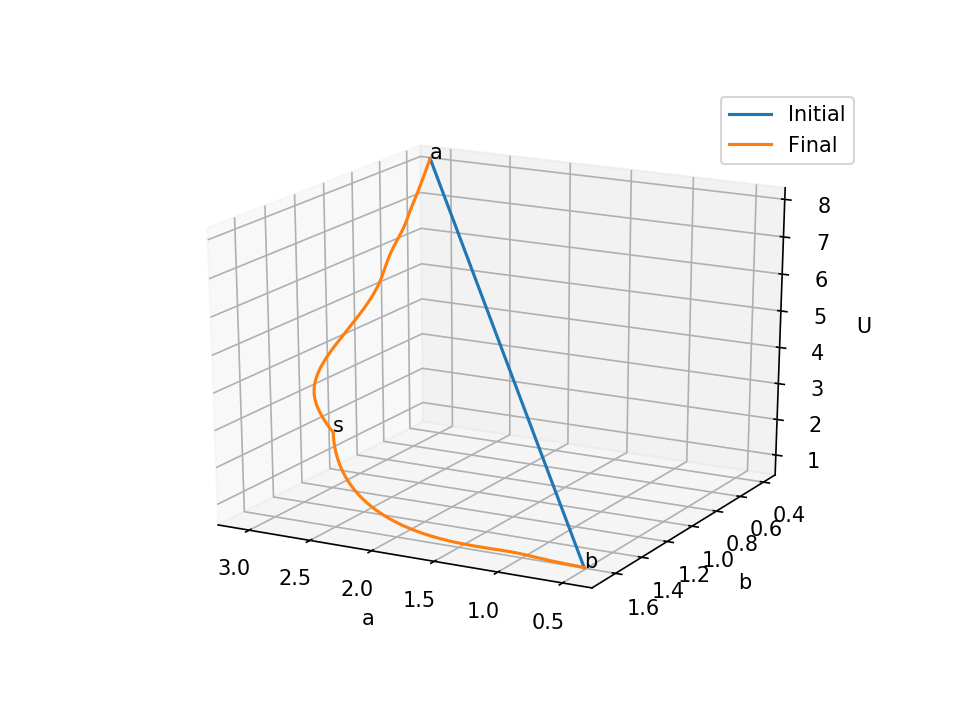

In [14]:
%matplotlib notebook

ts = np.linspace(-1, 1, 1000)

paths = [
    (m0, "Initial"),
    (m, "Final")
]

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

for p in paths:
    _m, _mlabel = p
    xs, vs = ff.evaluate_at(_m, ts)
    ax.plot(xs[:,0], xs[:,1], xs[:,2], label=_mlabel)
    
ax.text(e_xa[0], e_xa[1], e_xa[2], "a")
ax.text(e_xb[0], e_xb[1], e_xb[2], "b")
ax.text(e_xs[0], e_xs[1], e_xs[2], "s")

ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("U")

ax.legend()
plt.show()

In [16]:
ff.get_m_with_fixed_points(m)

array([3.06964439, 3.06091767, 3.04798834, 3.03671685, 3.02316794,
       3.00959741, 2.96553084, 3.02570158, 3.01936807, 2.8714219 ,
       2.80172701, 2.76693013, 2.52819787, 1.93090192, 1.27980158,
       0.92778601, 0.64320253, 0.46463458, 0.39165881, 0.45547233,
       0.54446592, 0.59856675, 0.68594545, 0.78574177, 0.96844357,
       1.20150412, 1.2922065 , 1.33516911, 1.35244401, 1.37892042,
       1.52255267, 1.67421873, 1.65739129, 1.6462044 , 1.65116174,
       1.65101267, 8.15004714, 7.69493208, 7.12929072, 6.79320151,
       6.36070482, 5.78874037, 5.05854861, 4.02630165, 3.05797164,
       2.53095309, 2.38574159, 2.29826383, 1.80675149, 1.05501391,
       0.7003533 , 0.6599442 , 0.61516283, 0.593924  ])

In [15]:
act.compute_lagrangian(m, np.linspace(-1, 1, 1000))[0]

array([6.37333650e-09, 3.81389508e+00, 6.93171263e+00, 9.45443144e+00,
       1.14695664e+01, 1.30529089e+01, 1.42700445e+01, 1.51776761e+01,
       1.58247781e+01, 1.62536020e+01, 1.65005541e+01, 1.65969595e+01,
       1.65697295e+01, 1.64419421e+01, 1.62333483e+01, 1.59608135e+01,
       1.56387013e+01, 1.52792089e+01, 1.48926579e+01, 1.44877482e+01,
       1.40717790e+01, 1.36508405e+01, 1.32299815e+01, 1.28133543e+01,
       1.24043411e+01, 1.20056636e+01, 1.16194785e+01, 1.12474600e+01,
       1.08908715e+01, 1.05506277e+01, 1.02273487e+01, 9.92140628e+00,
       9.63296444e+00, 9.36201400e+00, 9.10840265e+00, 8.87186083e+00,
       8.65202393e+00, 8.44845136e+00, 8.26064287e+00, 8.08805255e+00,
       7.93010066e+00, 7.78618378e+00, 7.65568335e+00, 7.53797281e+00,
       7.43242369e+00, 7.33841060e+00, 7.25531536e+00, 7.18253041e+00,
       7.11946156e+00, 7.06553016e+00, 7.02017481e+00, 6.98285269e+00,
       6.95304047e+00, 6.93023501e+00, 6.91395377e+00, 6.90373497e+00,
      

### Convergence

In [ ]:
import warnings; warnings.simplefilter('ignore')

acs = []

for i in range(1, 30):
    x_start = e_xb
    x_end = e_xs

    Nm = i
    Nq = Nm*60

    m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                        exclude_start_point=True, exclude_end_point=True)

    ff = pyritz.funcs.CollocationFF(Nm, dim, derivatives=1,
                                   fixed_start_point=x_start,
                                   fixed_end_point=x_end)

    quad_scheme = pyritz.quads.Q_clenshaw_curtis

    compute_gradient=True
    act = pyritz.Action(dim, ff, lagrangian, Nq, quad_scheme,
                        lagrangian_args=compute_gradient)

    def get_action(m, grad):
        if grad.size > 0:
            return act.compute(m, grad)
        else:
            return act.compute(m)

    opt = nlopt.opt(nlopt.LD_SLSQP, np.size(m0))
    opt.set_min_objective(get_action)
    opt.set_xtol_rel(1e-16)
    m = opt.optimize(m0)

    s = act.compute(m)
    
    # Compute accurate S
    
    act = pyritz.Action(dim, ff, lagrangian, Nq*40, quad_scheme,
                            lagrangian_args=compute_gradient)

    acc_s = act.compute(m)
    
    print("Nm:", Nm, "Nq:", Nq, "S:", s, "acc_S:", acc_s, "err_S:", np.abs(acc_s - s))
    
    acs.append( (Nm, Nq, s, m) )

In [ ]:
import warnings; warnings.simplefilter('ignore')

def lagrangian_args_generator(Nm, Nq, m, function_family):
    m[:] += (-1 + 2*np.random.random(len(m)))*0.05 # Add some noise to initial path
    return True

x_start = e_xb
x_end = e_xs

Nms = np.arange(1, 30)
Nqs = Nms*60

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nms[0],
                                    exclude_start_point=True, exclude_end_point=True)

ff = pyritz.funcs.CollocationFF(Nms[0], dim, derivatives=1,
                               fixed_start_point=x_start,
                               fixed_end_point=x_end)
quad_scheme = pyritz.quads.Q_clenshaw_curtis
compute_gradient=True

res = []
pyritz.utils.minimize_action_iteratively(Nms, Nqs, x_start, x_end, lagrangian, ff, quad_scheme, m0,
                           nlopt.LD_SLSQP, lagrangian_args=compute_gradient,
                           xtol_rel=1e-16, results=res,
                            lagrangian_args_generator=lagrangian_args_generator,
                            compute_accurate_S=True, compute_accurate_S_Nq_factor=40)